<a href="https://colab.research.google.com/github/samarth-91/hyperspectral-image-coffee-classifier/blob/main/IVP_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
from os import listdir
from os.path import isfile, join
import glob
import matplotlib.pyplot as plt
import skimage as sk

In [3]:
# iterate in directory and extract all images names

mypath='/content/drive/MyDrive/hyperspectral image/data/coffee'
onlyfiles = [ f for f in listdir(mypath) if isfile(join(mypath,f)) ] # get all images names
onlyfiles.sort() # sort by lowest-highest wavelength

In [4]:
def get_lightRoast(img):
    segment = img[10:75, 40:110]
    return segment

def get_deepRoast(img):
    segment = img[65:130, 105:175]
    return segment

def get_goodCoffee(img):
    segment = img[190:img.shape[0], 65:130]
    return segment

def get_dry(img):
    segment = img[80:125, 45:95]
    return segment

def get_skin(img):
    segment = img[120:175, 80:120]
    return segment

def get_mold(img):
    segment = img[155:200, 30:70]
    return segment

def get_bug(img):
    segment = img[155:205, 130:175]
    return segment

In [5]:
len(onlyfiles) - 28

68

In [6]:
main_path = 'TRAIN'
#os.makedirs(main_path)

folders = ['good_coffee', 'light_roast', 'deep_roast', 'skin', 'mold', 'bug']
for folder in folders:
    os.makedirs(name = main_path + '/' + folder)
    actual_path = './'+ main_path + '/'+ folder
    for file in onlyfiles[0:68]:
        img = sk.io.imread(mypath + "/" + file)
        sub_img_name = folder + '_' + file
        if folder == 'good_coffee':
            subimg = get_goodCoffee(img)
        elif folder == 'light_roast':
            subimg = get_lightRoast(img)
        elif folder == 'deep_roast':
            subimg = get_deepRoast(img)
        elif folder == 'skin':
            subimg = get_skin(img)
        elif folder == 'mold':
            subimg = get_mold(img)
        elif folder == 'bug':
            subimg = get_bug(img)
        sk.io.imsave(actual_path + '/'+sub_img_name, subimg)


In [7]:
main_path = 'TEST'
#os.makedirs(main_path)

folders = ['good_coffee', 'light_roast', 'deep_roast', 'skin', 'mold', 'bug']
for folder in folders:
    os.makedirs(name = main_path + '/' + folder)
    actual_path = './'+ main_path + '/'+ folder
    for file in onlyfiles[68:]:
        img = sk.io.imread(mypath + "/" + file)
        sub_img_name = folder + '_' + file
        if folder == 'good_coffee':
            subimg = get_goodCoffee(img)
        elif folder == 'light_roast':
            subimg = get_lightRoast(img)
        elif folder == 'deep_roast':
            subimg = get_deepRoast(img)
        elif folder == 'skin':
            subimg = get_skin(img)
        elif folder == 'mold':
            subimg = get_mold(img)
        elif folder == 'bug':
            subimg = get_bug(img)
        sk.io.imsave(actual_path + '/'+sub_img_name, subimg)

In [8]:
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Normalization, Dropout, Flatten
from keras.callbacks import EarlyStopping

In [9]:
src_path_train = "./TRAIN"
src_path_test = "./TEST"

train_datagen = ImageDataGenerator(
        rescale=1 / 255.0,
        rotation_range=20,
        zoom_range=0.05,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.05,
        horizontal_flip=True,
        fill_mode="nearest")

test_datagen = ImageDataGenerator(rescale=1 / 255.0,
        rotation_range=20,
        zoom_range=0.05,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.05,
        horizontal_flip=True,
        fill_mode="nearest")

In [10]:
batch_size = 16
train_generator = train_datagen.flow_from_directory(
    directory=src_path_train,
    target_size=(100, 100),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode="categorical",
    subset='training',
    shuffle=True,
    seed=123
)

test_generator = test_datagen.flow_from_directory(
    directory=src_path_test,
    target_size=(100, 100),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    seed=123
)

Found 408 images belonging to 6 classes.
Found 168 images belonging to 6 classes.


In [22]:
cb =  EarlyStopping(patience = 10)

epochs = 50

model = keras.Sequential()
model.add(Conv2D(8,kernel_size = 3, activation = 'relu'))
model.add(MaxPool2D(2))
model.add(Conv2D(16, kernel_size = 3, activation = 'relu'))
model.add(MaxPool2D(2))
model.add(Conv2D(32, kernel_size = 3, activation = 'relu'))
model.add(MaxPool2D(2))
model.add(Flatten())

model.add(Dense(128, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(6, activation = 'softmax'))

model.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy',
              metrics =['accuracy'])

history = model.fit_generator(
    generator = train_generator,
    validation_data = test_generator,
    epochs = epochs,
    callbacks = cb
)

<ipython-input-22-310aadee80d2>:24: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/50
26/26 [==============================] - 6s 162ms/step - loss: 1.7545 - accuracy: 0.1765 - val_loss: 1.7099 - val_accuracy: 0.2143
Epoch 2/50
26/26 [==============================] - 2s 93ms/step - loss: 1.3723 - accuracy: 0.4093 - val_loss: 1.3708 - val_accuracy: 0.5298
Epoch 3/50
26/26 [==============================] - 3s 102ms/step - loss: 0.7893 - accuracy: 0.7206 - val_loss: 0.9701 - val_accuracy: 0.6964
Epoch 4/50
26/26 [==============================] - 3s 102ms/step - loss: 0.3022 - accuracy: 0.9020 - val_loss: 1.0246 - val_accuracy: 0.5655
Epoch 5/50
26/26 [==============================] - 5s 186ms/step - loss: 0.2937 - accuracy: 0.9240 - val_loss: 0.8119 - val_accuracy: 0.6786
Epoch 6/50
26/26 [==============================] - 3s 103ms/step - loss: 0.0850 - accuracy: 0.9877 - val_loss: 0.5918 - val_accuracy: 0.7619
Epoch 7/50
26/26 [==============================] - 2s 93ms/step - loss: 0.0900 - accuracy: 0.9755 - val_loss: 0.6405 - val_accuracy: 0.7202
Epoch 8/

In [23]:
model.save('coffee_classifier.keras')

In [24]:
loss, accuracy = model.evaluate(test_generator)
print(f'Model has {accuracy * 100} % of accuracy')

11/11 [==============================] - 0s 34ms/step - loss: 0.8262 - accuracy: 0.8155
Model has 81.54761791229248 % of accuracy


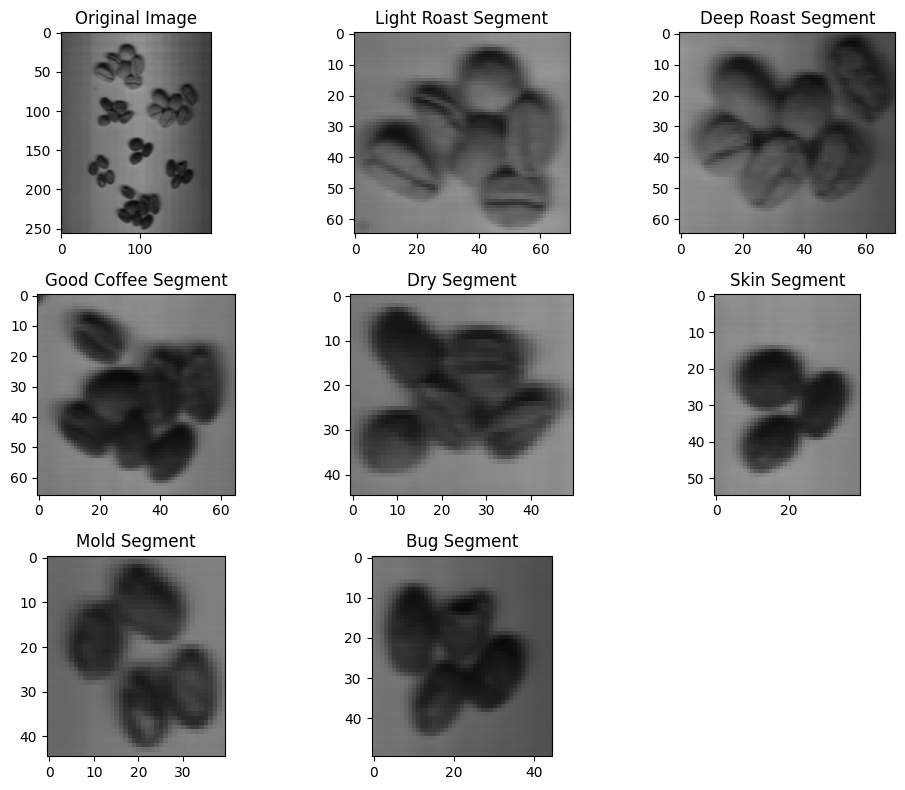

In [25]:
import cv2
import matplotlib.pyplot as plt

# Load your image (replace 'your_image_path.jpg' with the actual path to your image)
img_path = '/content/drive/MyDrive/hyperspectral image/data/coffee/coffee_1477nm.png'
img = cv2.imread(img_path)

# Call your segmentation functions
light_roast_segment = get_lightRoast(img)
deep_roast_segment = get_deepRoast(img)
good_coffee_segment = get_goodCoffee(img)
dry_segment = get_dry(img)
skin_segment = get_skin(img)
mold_segment = get_mold(img)
bug_segment = get_bug(img)

# Display the original image and segmented regions
plt.figure(figsize=(10, 8))

plt.subplot(3, 3, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original Image')

plt.subplot(3, 3, 2)
plt.imshow(cv2.cvtColor(light_roast_segment, cv2.COLOR_BGR2RGB))
plt.title('Light Roast Segment')

plt.subplot(3, 3, 3)
plt.imshow(cv2.cvtColor(deep_roast_segment, cv2.COLOR_BGR2RGB))
plt.title('Deep Roast Segment')

plt.subplot(3, 3, 4)
plt.imshow(cv2.cvtColor(good_coffee_segment, cv2.COLOR_BGR2RGB))
plt.title('Good Coffee Segment')

plt.subplot(3, 3, 5)
plt.imshow(cv2.cvtColor(dry_segment, cv2.COLOR_BGR2RGB))
plt.title('Dry Segment')

plt.subplot(3, 3, 6)
plt.imshow(cv2.cvtColor(skin_segment, cv2.COLOR_BGR2RGB))
plt.title('Skin Segment')

plt.subplot(3, 3, 7)
plt.imshow(cv2.cvtColor(mold_segment, cv2.COLOR_BGR2RGB))
plt.title('Mold Segment')

plt.subplot(3, 3, 8)
plt.imshow(cv2.cvtColor(bug_segment, cv2.COLOR_BGR2RGB))
plt.title('Bug Segment')

plt.tight_layout()
plt.show()
